In [130]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [131]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

## 클리닝 - 마이너스값, 미입고기간 없애고 시작함

In [133]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
# 해당 조건의 행 삭제
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [134]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [135]:
df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

# 리드타임이 0 미만이거나 200일 초과인 데이터 제거
df = df[df['리드타임'] > 0]
df = df[df['리드타임'] <= 200]

# 창고입고가 결측값인 행 제거
df = df.dropna(subset=['창고입고'])
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]
df = df[~df.index.isin(missing_both.index)]  # 제거

print(df.shape)

(19768, 33)


# 다중 출력 모델
### 리드타임 예측 (회귀) / 미입고 기간 예측 (분류) 
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. BERT 임베딩 유사도 => 모델의 입력, 2.3데이터 결합 => 리드타임 OR 미입고 기간 예측

### 전처리

In [108]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [173]:
# 텍스트 컬럼 리스트
text_columns = ['Machinery', 'Assembly', '청구품목' , '발주처']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)


In [174]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
    
def get_embeddings_batchwise(encodings, model, batch_size=16):
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], encodings['token_type_ids'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids = [t.to(device) for t in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            all_embeddings.append(outputs.pooler_output.cpu())

    return torch.cat(all_embeddings, dim=0)


machinery_encodings = encode_data(df['Machinery'])
machinery_embeddings = get_embeddings_batchwise(machinery_encodings, model, batch_size=16)

assembly_encodings = encode_data(df['Assembly'])
assembly_embeddings = get_embeddings_batchwise(assembly_encodings, model, batch_size=16)

item_encodings = encode_data(df['청구품목'])
item_embeddings = get_embeddings_batchwise(supplier_encodings, model, batch_size=16)

supplier_encodings = encode_data(df['발주처'])
supplier_embeddings = get_embeddings_batchwise(supplier_encodings, model, batch_size=16)

# 5. 각 임베딩을 데이터프레임에 추가
df['machinery_embedding'] = machinery_embeddings.tolist()  # 임베딩을 리스트로 변환 후 데이터프레임에 추가
df['assembly_embedding'] = assembly_embeddings.tolist()
df['item_embeddings'] = item_embeddings.tolist()
df['supplier_embedding'] = supplier_embeddings.tolist()

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 데이터 분할

In [175]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# 1. 화폐 단위 원핫 인코딩
currency_ohe = OneHotEncoder(sparse_output=False)
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

exchange_rate = {
    'KRW': 1/1300, 
    'USD': 1,      
    'EUR': 1.1,     
    'JPY': 1/110    
}

# 발주금액을 환율에 맞춰 USD로 변환
df['converted_unit_price'] = df.apply(lambda x: x['견적단가'] * exchange_rate[x['견적화폐']], axis=1)
df['converted_price'] = df['converted_unit_price'] * df['발주수량']

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 1. Machinery 텍스트 데이터를 TF-IDF로 벡터화 (최대 100개의 중요한 단어만 사용)
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Machinery'])

X_text = np.hstack([
    np.vstack(df['machinery_embedding']),
    np.vstack(df['assembly_embedding']),
    np.vstack(df['item_embeddings']),
    np.vstack(df['supplier_embedding'])
])

pca = PCA(n_components=50)
X_text_reduced = pca.fit_transform(X_text)

In [185]:

# 3. TF-IDF 벡터를 밀집 배열로 변환 (CSR matrix를 Numpy 배열로 변환)
X_tfidf = tfidf_matrix.toarray()  # 밀집 배열로 변환

# 4. 수치형 피처 (발주수량, 환산된 단가)
X_numeric = df[['converted_unit_price', '발주수량']].values
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

X_combined = np.hstack([X_text_reduced, X_tfidf, X_numeric_scaled, currency_encoded])


y = df['리드타임']

In [191]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_combined, y)

# 예측
predictions = rf_model.predict(X_combined)

In [192]:

# 14. MSE 계산
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

# MSE 및 RMSE 출력
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 391.1826482636533
RMSE: 19.77833785391617


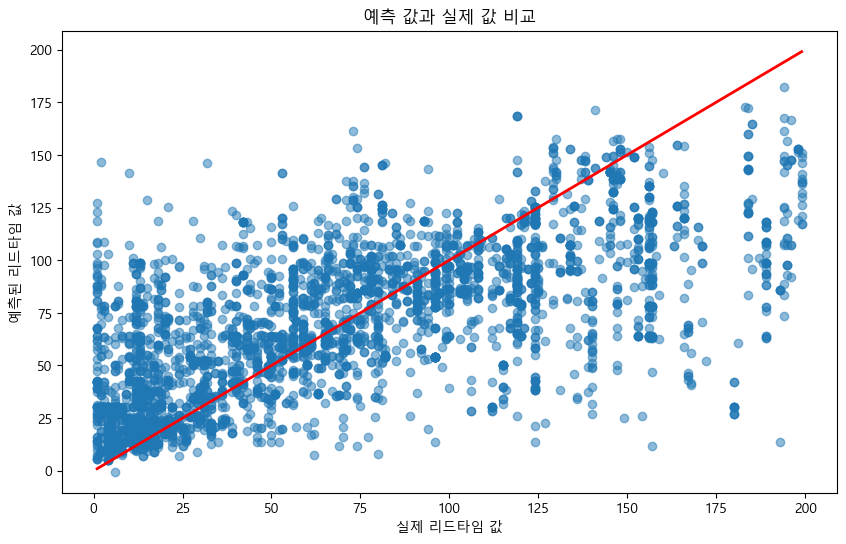

In [115]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("실제 리드타임 값")
plt.ylabel("예측된 리드타임 값")
plt.title("예측 값과 실제 값 비교")
plt.show()

In [116]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # MSE의 제곱근을 구하면 평균 오차 (RMSE)

print(f"평균 오차 (RMSE): {rmse}일")

평균 오차 (RMSE): 37.519057192699165일
